# Proje:  Meme Kanseri Histopatoloji Görüntü Sınıflandırma

**Amaç:** Bu proje, meme kanseri histopatoloji görüntülerinden İnvaziv Duktal Karsinom (Invasive Ductal Carcinoma - IDC) varlığını tespit etmeyi hedefler. Görüntüler, IDC Pozitif (kanserli) ve IDC Negatif (kansersiz) olmak üzere iki sınıfa ayrılacaktır.

**Yaklaşım:** Bu bir ikili görüntü sınıflandırma problemidir. Çözüm için, ImageNet veri kümesi üzerinde önceden eğitilmiş ResNet50 modeli, transfer öğrenme yaklaşımı ile kullanılacaktır. Veri seti çok büyük ve dengesiz olduğu için, sınıflar arası dengeyi sağlamak amacıyla azınlık sınıfının örnek sayısına göre çoğunluk sınıfından rastgele örnekler seçilerek dengeli bir alt veri seti oluşturulmuştur. Proje, veri ön işleme, veri artırma, modelin ilk eğitimi ve ince ayar (fine-tuning) adımlarını içermektedir.

# Adım 1: Gerekli Kütüphaneleri Import Etme, Sabit Değişkenleri Atama ve GPU'yu Test Etme

In [7]:
# Temel kütüphaneler
import os
import shutil
from pathlib import Path
import random
import glob

# Matematik ve veri işleme
import numpy as np
import pandas as pd
from tqdm import tqdm

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Görüntü işleme
import cv2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    TensorBoard
)
from tensorflow.keras.utils import plot_model, to_categorical

<h3> Sabitler ve Dosya Yolları </h3>
Metrikleri hızlıca değiştirmek için projeye eklenen sabitler ve dosya yolları

In [ ]:
# Parametreler
IMAGE_SIZE = 50 
BATCH_SIZE = 8
NUM_CLASSES = 2
EPOCHS = 50 
FINE_TUNE_EPOCHS = 20
LEARNING_RATE = 0.0001
FINE_TUNE_LR = 1e-6

# Yollar
DATA_DIR = '../BrainCancerClassification/BrainCancerClassification/Data/BreastCancerHP'
OUTPUT_DIR = Path('ML-Models')
MODEL_NAME = 'ResNet50_best_breast_cancer.h5'
LOGS_DIRECTORY = Path('Logs-of-BreastCancer-ResNet50')

# Modelin önceki loglarını ve çıktılarını temizle
if LOGS_DIRECTORY.exists():
    shutil.rmtree(LOGS_DIRECTORY)
if OUTPUT_DIR.exists():
    shutil.rmtree(OUTPUT_DIR)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
model_path = OUTPUT_DIR / MODEL_NAME

# Etiketler
# 0: IDC Negatif (Kansersiz), 1: IDC Pozitif (Kanserli)
LABELS = ['IDC (-)', 'IDC (+)']

<h3> Ekran Kartı Testi ve Karma Hassasiyet Kurulumu(float16)</h3>

In [9]:
print("--- GPU Setup Initilasing ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPU, {len(logical_gpus)} Logical GPU found.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU Detected, will continue with CPU.")
print("--- GPU Setup Completed ---")

if gpus:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed float policy enabled.")

--- GPU Setup Initilasing ---
1 Physical GPU, 1 Logical GPU found.
--- GPU Setup Completed ---
Mixed float policy enabled.


# Adım 2: Veri Keşfi, Yükleme ve Dengeleme

In [ ]:
image_paths = glob.glob(os.path.join(DATA_DIR, '**', '*.png'), recursive=True)
print(f"Toplam bulunan görsel sayısı: {len(image_paths)}")

path_label_pairs = {path: int(path.split('_class')[1].split('.png')[0]) for path in image_paths}


df = pd.DataFrame({"path": list(path_label_pairs.keys()), "label": list(path_label_pairs.values())})

print("\nDengeleme öncesi sınıf dağılımı:")
print(df['label'].value_counts())

idc_pos_df = df[df['label'] == 1]
idc_neg_df = df[df['label'] == 0]

idc_neg_sampled_df = idc_neg_df.sample(n=len(idc_pos_df), random_state=42)

balanced_df = pd.concat([idc_pos_df, idc_neg_sampled_df]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nDengeleme sonrası sınıf dağılımı:")
print(balanced_df['label'].value_counts())

Toplam bulunan görsel sayısı: 555048

Dengeleme öncesi sınıf dağılımı:
label
0    397476
1    157572
Name: count, dtype: int64

Dengeleme sonrası sınıf dağılımı:
label
0    157572
1    157572
Name: count, dtype: int64


# Adım 3: Veri Setlerini Ayırma (Eğitim, Doğrulama, Test)

In [ ]:
train_df, test_val_df = train_test_split(
    balanced_df,
    train_size=0.7,
    random_state=42,
    stratify=balanced_df['label']
)

test_df, val_df = train_test_split(
    test_val_df,
    train_size=0.5,
    random_state=42,
    stratify=test_val_df['label']
)

print(f"\nEğitim seti boyutu: {len(train_df)}")
print(f"Doğrulama seti boyutu: {len(val_df)}")
print(f"Test seti boyutu: {len(test_df)}")


Eğitim seti boyutu: 220600
Doğrulama seti boyutu: 47272
Test seti boyutu: 47272


# Adım 4: Veri Yükleyici Fonksiyon ve Ön İşleme

In [ ]:
def load_images_from_df(df, image_size):
    images = []
    labels = []
    
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Görseller yükleniyor"):
        image = cv2.imread(row['path'])
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = cv2.resize(image, (image_size, image_size))
            images.append(image)
            labels.append(row['label'])
            
    images = np.array(images, dtype=np.float32) / 255.0 
    labels = np.array(labels, dtype=np.int32)
    
    return images, labels

# Veri setlerini yükle
x_train, y_train = load_images_from_df(train_df, IMAGE_SIZE)
x_val, y_val = load_images_from_df(val_df, IMAGE_SIZE)
x_test, y_test = load_images_from_df(test_df, IMAGE_SIZE)

# Etiketleri One-Hot Encoding formatına çevir
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"\nx_train şekli: {x_train.shape}")
print(f"y_train_cat şekli: {y_train_cat.shape}")

Görseller yükleniyor:   5%|▍         | 10532/220600 [00:48<16:07, 217.15it/s]


KeyboardInterrupt: 

# Adım 5: ResNet50 Modelinin Oluşturulması (Veri Artırma ile)

Bu aşamada, transfer öğrenme yaklaşımıyla ResNet50 modeli oluşturulur. ImageNet ağırlıklarıyla yüklenen ResNet50'nin evrişimsel tabanı dondurulur ve üzerine özel bir sınıflandırma başlığı eklenir. Sadece bu başlık eğitilecektir.

In [ ]:


def create_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Modeli oluştur ve derle
resnet_model = create_resnet50_model((IMAGE_SIZE, IMAGE_SIZE, 3), NUM_CLASSES)
resnet_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 224)               458976    
                                                                 
 dropout (Dropout)           (None, 224)               0     

# Adım 6: Geri Çağırma (Callback) Fonksiyonlarının Tanımlanması

Bu aşamada, modelin eğitimi için EarlyStopping, ReduceLROnPlateau ve ModelCheckpoint gibi geri çağırmalar (callbacks) tanımlanır. Bu geri çağırmalar, aşırı öğrenmeyi önlemek, öğrenme oranını ayarlamak ve en iyi modeli kaydetmek için kullanılır. Son olarak, model SMOTE ile dengelenmiş ve artırılmış eğitim verileri kullanılarak model.fit() ile eğitilirken, bu süreç boyunca TensorBoard ile performansı izlenir.

In [ ]:
logdir = LOGS_DIRECTORY
logdir.mkdir(parents=True, exist_ok=True)

checkpoint_cb = ModelCheckpoint(filepath=str(model_path), monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1, min_lr=1e-7)
tensorboard_cb = TensorBoard(log_dir=str(logdir))

callbacks_list = [early_stopping_cb, reduce_lr_cb, checkpoint_cb, tensorboard_cb]


Logs will be saved to: Logs-of-ChestCancer-ResNet50


# Adım 7: Modelin Eğitimi

In [ ]:
print("--- İlk Eğitim Aşaması Başlıyor (Sadece Üst Katmanlar) ---")
history = resnet_model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list
)

# Sonuçları görselleştir
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.title("İlk Eğitim Aşaması Sonuçları")
plt.show()

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.5924 - accuracy: 0.2788
Epoch 1: val_loss improved from inf to 1.60154, saving model to ML-Models\ResNet50_best_chest.h5
20/20 [==============================] - 13s 252ms/step - loss: 1.5924 - accuracy: 0.2788 - val_loss: 1.6015 - val_accuracy: 0.2520 - lr: 1.0000e-05
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 1.4473 - accuracy: 0.3141
Epoch 2: val_loss improved from 1.60154 to 1.54351, saving model to ML-Models\ResNet50_best_chest.h5
20/20 [==============================] - 4s 201ms/step - loss: 1.4412 - accuracy: 0.3173 - val_loss: 1.5435 - val_accuracy: 0.2520 - lr: 1.0000e-05
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.3878
Epoch 3: val_loss improved from 1.54351 to 1.49137, saving model to ML-Models\ResNet50_best_chest.h5
20/20 [==============================] - 4s 219ms/step - loss: 1.3136 - accuracy: 0.3878 - val_loss: 1.4914 - val_accuracy

# Adım 8: Eğitim Performansının Görselleştirilmesi

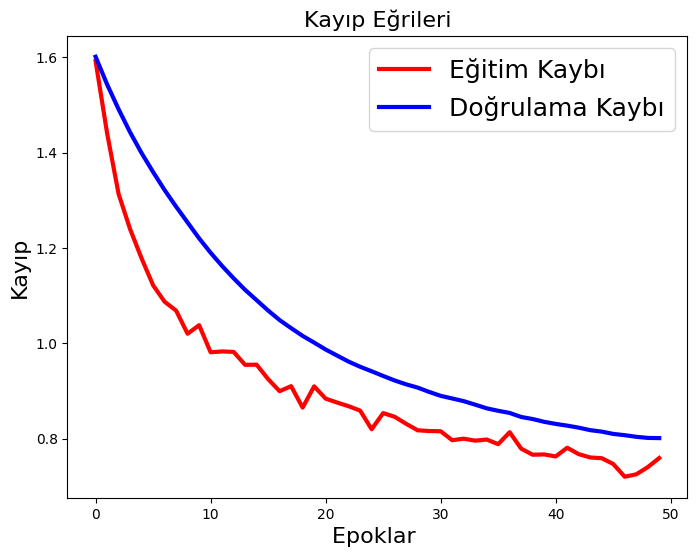

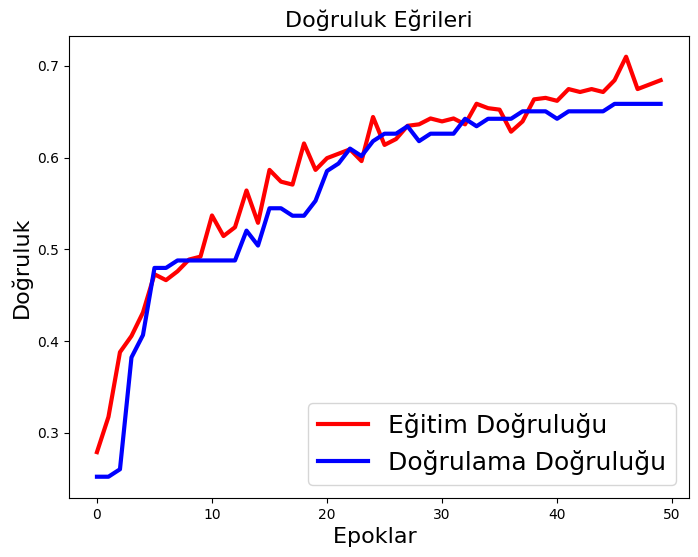

In [ ]:
print("\n--- Fine-Tuning Aşamasına Geçiliyor ---")
resnet_model.get_layer('resnet50').trainable = True

for layer in resnet_model.get_layer('resnet50').layers[:-30]:
    layer.trainable = False

resnet_model.compile(optimizer=optimizers.Adam(learning_rate=FINE_TUNE_LR),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_fine_tune = resnet_model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1] + 1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list
)

for key in history.history.keys():
    history.history[key].extend(history_fine_tune.history[key])

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Tüm Eğitim Süreci (Fine-Tuning Dahil)")
plt.show()

# Adım 9: Modelin Değerlendirilmesi


--- Modelin Son Değerlendirilmesi ---
10/10 [==============================] - 1s 56ms/step - loss: 0.9869 - accuracy: 0.6032

Test Seti Kaybı: 0.9869
Test Seti Doğruluğu: 60.32%

Sınıflandırma Raporu:
                         precision    recall  f1-score   support

         adenocarcinoma       0.67      0.48      0.56       120
   large.cell.carcinoma       0.52      0.45      0.48        51
                 normal       0.69      1.00      0.82        54
squamous.cell.carcinoma       0.53      0.62      0.57        90

               accuracy                           0.61       315
              macro avg       0.60      0.64      0.61       315
           weighted avg       0.61      0.61      0.60       315


Test Seti Karışıklık Matrisi:


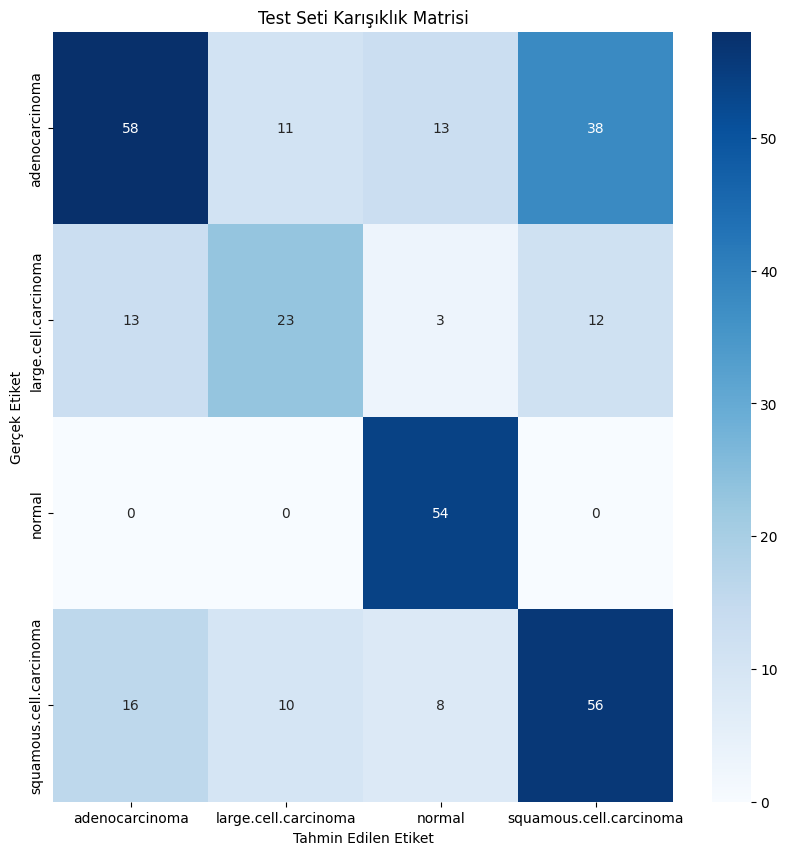

10/10 [==============================] - 0s 42ms/step - loss: 0.9869 - accuracy: 0.6032


In [ ]:
# En iyi model ağırlıklarını yükle
resnet_model.load_weights(str(model_path))

print("\n--- Modelin Test Seti ile Son Değerlendirilmesi ---")
loss, acc = resnet_model.evaluate(x_test, y_test_cat)
print(f"\nTest Seti Kaybı: {loss:.4f}")
print(f"Test Seti Doğruluğu: {acc*100:.2f}%")

# Tahminleri yap
y_pred_probs = resnet_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Rapor ve Karışıklık Matrisi (etiketlerin integer haliyle: y_test)
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=LABELS))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

In [ ]:
final_model_path = OUTPUT_DIR / 'ResNet50_breastcancer_model.h5'
resnet_model.save(final_model_path)
print(f"\nEğitilmiş son model şuraya kaydedildi: {final_model_path}")

ValueError: in user code:

    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\mehme\anaconda3\envs\tensorflow_gpu_model\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible
